In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pathlib import Path
import sys

# Add src/ to Python path
project_root = Path.cwd().parent  # assuming notebook is inside notebooks/
src_path = project_root / "src"
sys.path.insert(0, str(src_path))

from model.pixel_pred_models.base import PixelPredictionModel
from model.pixel_pred_models.random_forest_regression import RandomForestRegression
from data_src.gridded_data_sources.cetb import CETBScene
from data_src.gridded_data_sources.era5 import ERA5Scene
from utils.grid_utils import Grid

In [2]:
cetb_scene = CETBScene.from_files(r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\raw_data\CETB_AMSR2\2022-04\NSIDC0630_SIR_EASE2_N3.125km_GCOMW1_AMSR2_E_36H_20220401_2409032033_v2.0.nc")
cetb_scene.modify_extent([-4500000, -4500000, 4500000, 4500000])

era5_scene = ERA5Scene.from_dir(r"C:\Users\ehate\Desktop\ASP\ASP_code_projects\raw_data\ERA5_daily_raw_v2\2022_04")

era5_scene.regrid(cetb_scene.grid, method='linear')
scene = cetb_scene + era5_scene

In [3]:
data_dir = 'C:/Users/ehate/Desktop/ASP/ASP_code_projects/ASP_RF_modelling/data/'
train_file = data_dir + 'SD_CETB_ERA5-derived_LARM-smoothed_3.125km_v1.0_train_data.parquet'
test_file = data_dir + 'SD_CETB_ERA5-derived_LARM-smoothed_3.125km_v1.0_test_data.parquet'
  
main_input_param = ['36H']
second_input_param = ['t2m','tcwv', 'tclw', 'tciw']

input_param = main_input_param + second_input_param
target_param = ['SD_mean']

params = {'n_estimators': 30, 
           'min_weight_fraction_leaf': 0.0, 
           'min_samples_split': 15, 
           'min_samples_leaf': 1, 
           'max_samples': None, 
           'max_features': 1.0, 
           'max_depth': 20, 
           'criterion': 'squared_error', 
           'bootstrap': True}

In [4]:
# load train and test data
train_data = pd.read_parquet(train_file)
test_data = pd.read_parquet(test_file)

In [5]:
model = RandomForestRegression(grid=scene.grid, model_params=params, random_state=42)
model.train(train_data[input_param], train_data[target_param[0]])

PixelPredictionModel with input features: ['36H', 't2m', 'tcwv', 'tclw', 'tciw'] and target feature: SD_mean


In [6]:
scene.data

<xarray.Dataset> Size: 697MB
Dimensions:  (time: 1, y: 2880, x: 2880)
Coordinates:
  * time     (time) datetime64[ns] 8B 2022-04-01
  * y        (y) float64 23kB 4.498e+06 4.495e+06 ... -4.495e+06 -4.498e+06
  * x        (x) float64 23kB -4.498e+06 -4.495e+06 ... 4.495e+06 4.498e+06
Data variables: (12/21)
    36H      (time, y, x) float32 33MB dask.array<chunksize=(1, 1440, 1440), meta=np.ndarray>
    u10      (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    v10      (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    d2m      (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    t2m      (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    e        (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    ...       ...
    ssrd     (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    strd     (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    tciw     (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    tclw     (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    tcwv     (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>
    tp       (time, y, x) float32 33MB dask.array<chunksize=(1, 2880, 2880), meta=np.ndarray>

In [7]:
out = model.predict(scene)

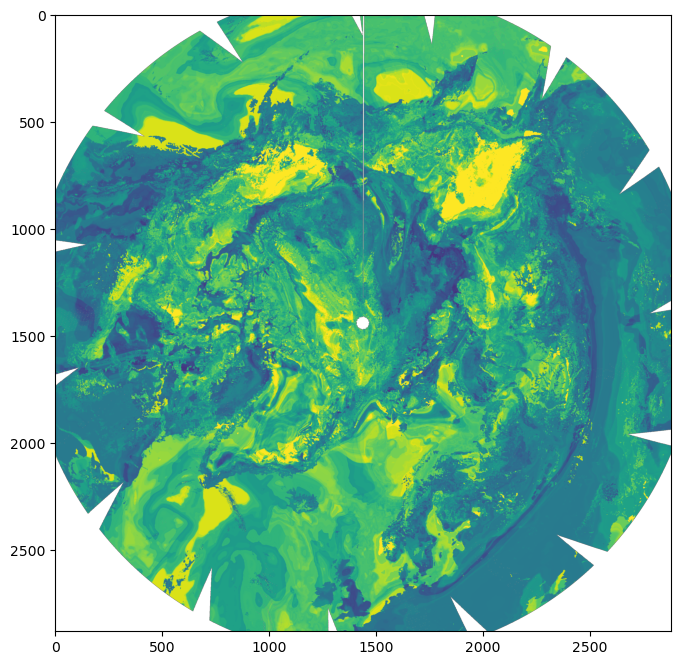

In [11]:
plt.figure(figsize=(10, 8))
plt.imshow(out.data['SD_mean'][0], vmin=0, vmax=0.3)

In [14]:
model.save('rf_model_test.pkl')

In [15]:
new_model = PixelPredictionModel.load('rf_model_test.pkl')

In [ ]:
9000000
4341882

In [56]:
from pyproj import Transformer

transformer = Transformer.from_crs( "EPSG:4326","EPSG:6931", always_xy=True)
x, y = transformer.transform(-179.8, 65)
print(x, y)

-9664.071150866212 2768541.20462741
